# Tutorial 2 - Windowing

### Purpose



At the end of the notebook, there will be an optional (starred) section:

**(\*):** Figures for the windowing section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

### 0.B. Sample description and experimental parameters

### 0.C. Let's get started


In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_names_fast = [
    'MAIN/PS_252nm/fast.nd2',
    'OBJECTIVE_MAGNIFICATION/PS_252nm_10x/fast.nd2',
    'OBJECTIVE_NA/PS_252nm_60x_NA_1-27/fast.nd2',
]

# create full paths
file_paths_fast = [os.path.join(main_directory, fn) for fn in file_names_fast]

# low frame rate videos file names (including enclosing folder)
file_names_slow = [
    'MAIN/PS_252nm/slow.nd2',
    'OBJECTIVE_MAGNIFICATION/PS_252nm_10x/slow.nd2',
    'OBJECTIVE_NA/PS_252nm_60x_NA_1-27/slow.nd2',
]

# create full paths
file_paths_slow = [os.path.join(main_directory, fn) for fn in file_names_slow]

# list of labels
labels = [
    r'20x, NA$_o$ 0.7',
    r'10x, NA$_o$ 0.45',
    r'60x, NA$_o$ 1.27',
]

In [3]:
# experimental acquisition parameters
magnification = [20, 10, 60]
pixel_size = [6.5 / mag for mag in magnification]  # microns per pixel

frame_rate_fast = 107    # frames per second
frame_rate_slow = 1      # frames per second

## 1. Structure function calculation and fit

### 1.A. Load and visualize images

<IPython.core.display.Javascript object>


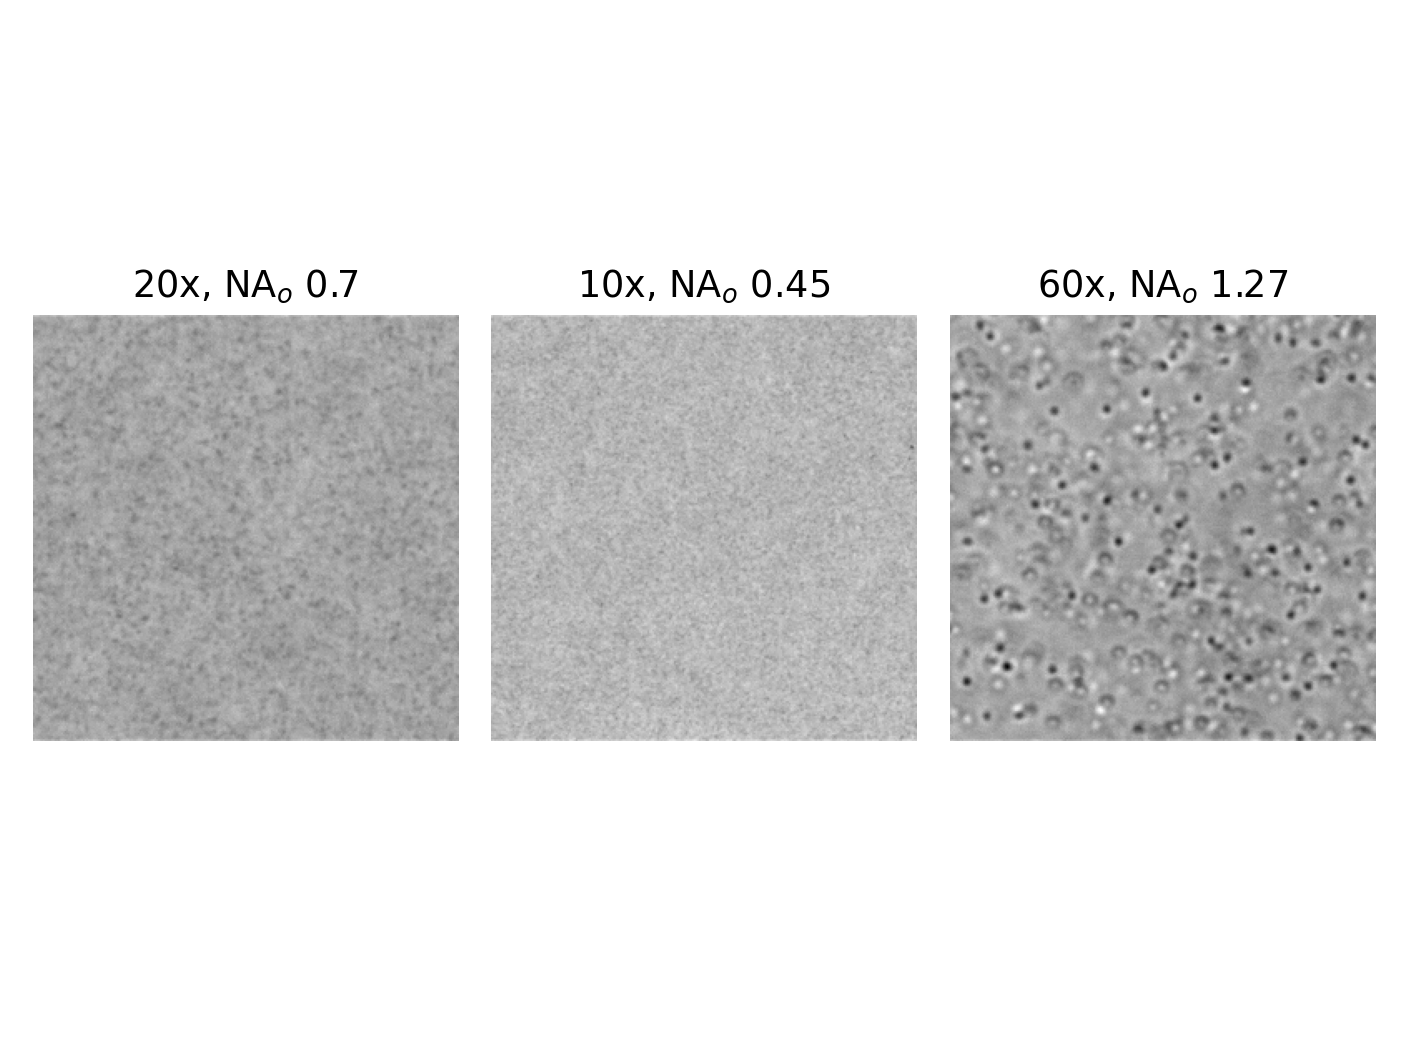

In [4]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=3)
axs = gs.subplots()

# read the images
images = []
for path in file_paths_fast:
    images.append(fd.read_images(path, seq=[0])[0])
images = np.array(images)

# compute max and min
vmin = np.min(images)
vmax = np.max(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

### 1.B-C. Structure function and azimuthal average calculation

In [5]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
#CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

aa = []

for n, (ffast, fslow) in enumerate(zip(file_paths_fast, file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie, set #{n+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(ffast)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[n]
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie, set #{n+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fslow)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[n]
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa_melt = fd.azimuthalaverage.melt(aa_fast, aa_slow)
    
    # resample
    # get 200 logspaced integers and rescale then with proper time
    max_tau = int(aa_melt.tau[-1] / aa_melt.tau[0])
    new_taus = fd.lags.logspace_int(max_tau, num=200, endpoint=True) * aa_melt.tau[0]
    aa.append(aa_melt.resample(new_taus))
    
    # delete unused variables
    del aa_fast, aa_slow, aa_melt
    gc.collect()

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie, set #1 of 3 ...
Analyzing slow movie, set #1 of 3 ...
Analyzing fast movie, set #2 of 3 ...
Analyzing slow movie, set #2 of 3 ...
Analyzing fast movie, set #3 of 3 ...
Analyzing slow movie, set #3 of 3 ...


### 1.D. Estimate noise and amplitude

In [ ]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    # estimate noise term using the 'polynomial' method
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq.append(B_est)
    
    # estimate total amplitude
    Aq_plus_Bq = 2 * a.var
    
    # estimate static amplitude 
    Aq.append(Aq_plus_Bq - B_est)

### 1.E. Fit with simple exponential model

In [ ]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate...

In [ ]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=False, return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Visualize the output from the fit...

In [ ]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# select range of wave vector indices
q_min = 0.1
q_max = 5

idx_min = np.argmin(np.abs(aa[0].k - q_min))
idx_max = np.argmin(np.abs(aa[0].k - q_max))
k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

cspace = color_space(len(k_list))

# plot curves
for ax, a, fr, mr, l in zip(axs, aa, fit_res, model_res, labels):
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (a.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(a.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

Visualize the fit parameters...

In [ ]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

## 2. Effect of windowing

### 2.A. Create window function for images

In [ ]:
# read one image
image = fd.read_images(file_paths_fast[-1], seq=[0])[0]

# create window function
window = fd.window.blackman_harris(image.shape)

# visualize window and its effect on the image
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

axs[0].imshow(window)
axs[0].set_axis_off()
axs[0].set_title('Blackman-Harris window')

axs[1].imshow(image * window, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Windowed image')

### 2.B-C. Structure function and azimuthal average calculation

In [ ]:
print('--- Calculating structure functions and azimuthal averages using windowing... ---')

aa_window = []

for n, (ffast, fslow) in enumerate(zip(file_paths_fast, file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie, set #{n+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(ffast)
    
    # create window function
    window = fd.window.blackman_harris(img_seq.shape)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE, window=window)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[n]
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie, set #{n+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fslow)
    
    # create window function
    window = fd.window.blackman_harris(img_seq.shape)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE, window=window)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[n]
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa_melt = fd.azimuthalaverage.melt(aa_fast, aa_slow)
    
    # resample
    # get 200 logspaced integers and rescale then with proper time
    max_tau = int(aa_melt.tau[-1] / aa_melt.tau[0])
    new_taus = fd.lags.logspace_int(max_tau, num=200, endpoint=True) * aa_melt.tau[0]
    aa_window.append(aa_melt.resample(new_taus))
    
    # delete unused variables
    del aa_fast, aa_slow, aa_melt
    gc.collect()

### 2.D. Estimate noise and amplitude

In [ ]:
# estimate noise and amplitude terms
Bq_window = []
Aq_window = []

for a in aa_window:
    # estimate noise term using the 'polynomial' method
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq_window.append(B_est)
    
    # estimate total amplitude
    Aq_plus_Bq = 2 * a.var
    
    # estimate static amplitude 
    Aq_window.append(Aq_plus_Bq - B_est)

### 2.E. Fit with simple exponential model

To initiate...

In [ ]:
# initialize lists
fit_res_window = []
model_res_window = []

for a, B, A in zip(aa_window, Bq_window, Aq_window):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=False, return_model_results=True)
    fit_res_window.append(fr)
    model_res_window.append(mr)